## 1. Importing required libraries

In [ ]:
import torch
from torch_geometric.utils import to_networkx
import networkx as nx
import operator
from torch_geometric.loader import LinkNeighborLoader
from sklearn.metrics import roc_auc_score, precision_score, recall_score, precision_recall_curve
from torch_geometric.datasets import MovieLens
import numpy as np

In [ ]:
# Install required packages.
import os
os.environ['TORCH'] = torch.__version__

!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in links: https://data.pyg.org/whl/torch-${TORCH}.html
     -------------------------------------- 108.0/108.0 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for torch-scatter
Failed to build torch-scatter


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [39 lines of output]
  No CUDA runtime is found, using CUDA_HOME='C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.6'
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.9
  creating build\lib.win-amd64-3.9\torch_scatter
  copying torch_scatter\placeholder.py -> build\lib.win-amd64-3.9\torch_scatter
  copying torch_scatter\scatter.py -> build\lib.win-amd64-3.9\torch_scatter
  copying torch_scatter\segment_coo.py -> build\lib.win-amd64-3.9\torch_scatter
  copying torch_scatter\segment_csr.py -> build\lib.win-amd64-3.9\torch_scatter
  copying torch_scatter\testing.py -> build\lib.win-amd64-3.9\torch_scatter
  copying torch_scatter\utils.py -> build\lib.win-amd64-3.9\torch_scatter
  copying torch_scatter\__init__.py -> build\lib.win-amd64-3.9\torch_scatter
  creating build\lib.win-amd64-3.9\torch_scatter\composite

Looking in links: https://data.pyg.org/whl/torch-${TORCH}.html
     -------------------------------------- 210.0/210.0 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for torch-sparse
Failed to build torch-sparse


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [64 lines of output]
  No CUDA runtime is found, using CUDA_HOME='C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.6'
  running bdist_wheel
  D:\Anaconda\envs\deeplearning\lib\site-packages\torch\utils\cpp_extension.py:387: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
    warnings.warn(msg.format('we could not find ninja.'))
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.9
  creating build\lib.win-amd64-3.9\torch_sparse
  copying torch_sparse\add.py -> build\lib.win-amd64-3.9\torch_sparse
  copying torch_sparse\bandwidth.py -> build\lib.win-amd64-3.9\torch_sparse
  copying torch_sparse\cat.py -> build\lib.win-amd64-3.9\torch_sparse
  copying torch_sparse\coalesce.py -> build\lib.win-amd64-3.9\torch_sparse
  copying torch_sparse\

Looking in links: https://data.pyg.org/whl/nightly/torch-${TORCH}.html


ERROR: Could not find a version that satisfies the requirement pyg-lib (from versions: none)
ERROR: No matching distribution found for pyg-lib


  Cloning https://github.com/pyg-team/pytorch_geometric.git to c:\users\admin\appdata\local\temp\pip-req-build-boawe4ra
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit dd1a5be993e902593a10767fb124168a4bc9c5b5
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git 'C:\Users\admin\AppData\Local\Temp\pip-req-build-boawe4ra'


## 2. Loading datasets

In [ ]:
main_data = MovieLens(root='../data/movielens')[0]
print(main_data)

HeteroData(
  movie={ x=[9742, 404] },
  user={ num_nodes=610 },
  (user, rates, movie)={
    edge_index=[2, 100836],
    edge_label=[100836],
  }
)


In [ ]:
train_data = torch.load('../data/movielens/train.pt')
val_data = torch.load('../data/movielens/test.pt')
test_data = torch.load('../data/movielens/val.pt')

## Make 2 graphs

In [ ]:
G_main = to_networkx(train_data)

In [ ]:
G_train = to_networkx(val_data)

## Evaluation

#### For each user, run personalised page rank on the main dgraph and compare it with the edges in the validation graph.

In [ ]:
users = val_data['user', 'rates', 'movie'].edge_index[0]
corr_edges = val_data['user', 'rates', 'movie'].edge_index[1]

In [ ]:
pred_total = []

In [ ]:
def get_auc_user(users, corr_edges, user):
    ## Actual movies
    movies_actual = np.zeros(9742)
    ct = 0
    for i in range(0, len(users)):
        if users[i] == user:
            movies_actual[corr_edges[i]] = 1
            ct+=1
    ## Pred movies
    ppr = nx.pagerank(G_main, personalization={user:1})
    ppr = sorted(ppr.items(), key=operator.itemgetter(1), reverse=True)
    i = 0
    movies_pred = np.zeros(9742)
    for item, score in ppr:
        if item >= 610 and i < ct:
            movies_pred[item-610] = 1
            i+=1

    auc = roc_auc_score(movies_actual, movies_pred)

    return auc, movies_actual, movies_pred

In [ ]:
def get_average_auc():

    actual_total = []
    pred_total = []

    auc = 0

    for i in range(0, 609):

        temp_1, temp_2, temp_3 = get_auc_user(users, corr_edges, i)

        auc += temp_1
        actual_total += list(temp_2)
        pred_total += list(temp_3)

    return float(auc / 610), actual_total, pred_total

In [ ]:
auc, actual_total, pred_total = get_average_auc()

In [ ]:
auc

0.4969943866920989

In [ ]:
auc, movies_actual_ex, movies_pred_ex = get_auc_user(users)

TypeError: get_auc_user() missing 2 required positional arguments: 'corr_edges' and 'user'

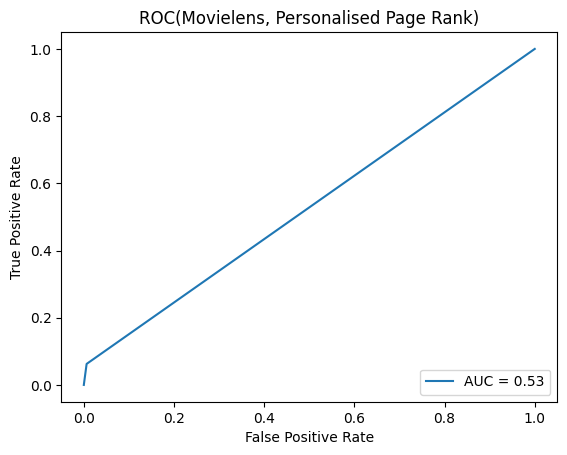

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
y = np.array([0, 0, 1, 1])
pred = np.array([0.1, 0.4, 0.35, 0.8])
fpr, tpr, thresholds = metrics.roc_curve(temp_2, temp_3)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  )
display.plot()
plt.title("ROC(Movielens, Personalised Page Rank)")

plt.show()

In [ ]:
[1] + [2]

[1, 2]

In [ ]:
temp_1, temp_2, temp_3 = get_auc_user(users, corr_edges, 10)

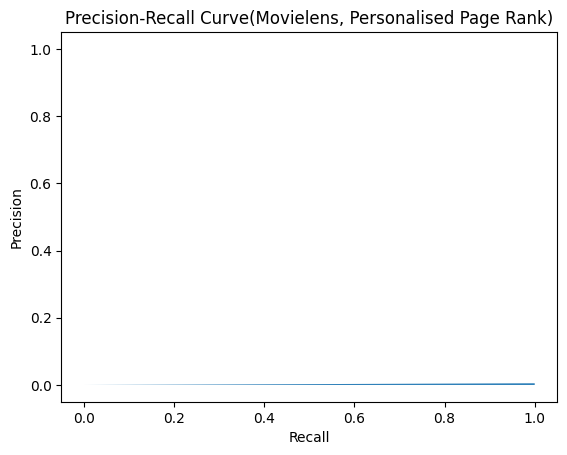

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
y = np.array([0, 0, 1, 1])
pred = np.array([0.1, 0.4, 0.35, 0.8])
precision, recall, thresholds = precision_recall_curve(temp_2, temp_3)
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall Curve(Movielens, Personalised Page Rank)")

plt.show()